In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import f_oneway
from scipy.stats import shapiro
import pandas as pd
from scipy.stats import chi2_contingency


import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#to make the interactive maps
import folium #Biblioteca para crear mapas interactivos basados en Leaflet.js.
from folium.plugins import FastMarkerCluster #Biblioteca para crear clusters de marcadores en un mapa interactivo.
import geopandas as gpd #Biblioteca para trabajar con datos geoespaciales.
from branca.colormap import LinearColormap #Biblioteca para crear colores personalizados en mapas.

#to make the plotly graphs
#from chart_studio import plotly # Biblioteca para crear mapas interactivos basados en Leaflet.js.
import cufflinks #Conector entre pandas y plotly para gráficos rápidos y sencillos desde DataFrames.
cufflinks.go_offline(connected=True) # Configuración para habilitar gráficos de cufflinks offline.

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords#take out empty comments (530)
from sklearn.feature_extraction.text import CountVectorizer 


Insideairbnb.com es un sitio web en el que se publican conjuntos de datos web scrapeados de «instantáneas» de ciudades. He descargado los archivos de Ámsterdam de la situación el 6 de diciembre de 2018. Me ha parecido un conjunto de datos divertido. Además de la manipulación básica de datos y gráficos, también he añadido mapas interactivos Folium, gráficos interactivos plotly, y la minería de texto de los comentarios de revisión.

## Los ficheros de listados y detalles de listados
El conjunto de datos que he creado contiene un total de 7 archivos. El archivo de listados es un archivo general que insideairbnb etiqueta como «bueno para visualizaciones». El identificador único del conjunto de datos es el identificador del anuncio. En total, había 20.030 anuncios de Airbnb en Ámsterdam el 6 de diciembre de 2018.

In [4]:
os.getcwd()

'/Users/angelg.villanueva/Documents/04 DATA-CB-PROGRAM/DS1024_2/2-DataAnalysis/10-EDA/EDA_Ronald'

In [5]:
listings = pd.read_csv("input/listings.csv", index_col= "id")
listings_details = pd.read_csv("input/listings_details.csv", index_col= "id", low_memory=False)
calendar = pd.read_csv("input/calendar.csv", parse_dates=['date'], index_col=['listing_id'])
reviews_details = pd.read_csv("input/reviews_details.csv", parse_dates=['date']) #, index_col=['id'])

In [6]:
for i in [listings, listings_details, calendar, reviews_details]:
    print(i.shape)

(20030, 15)
(20030, 95)
(7310950, 3)
(431830, 6)


In [7]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20030 entries, 2818 to 30580413
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            19992 non-null  object 
 1   host_id                         20030 non-null  int64  
 2   host_name                       20026 non-null  object 
 3   neighbourhood_group             0 non-null      float64
 4   neighbourhood                   20030 non-null  object 
 5   latitude                        20030 non-null  float64
 6   longitude                       20030 non-null  float64
 7   room_type                       20030 non-null  object 
 8   price                           20030 non-null  int64  
 9   minimum_nights                  20030 non-null  int64  
 10  number_of_reviews               20030 non-null  int64  
 11  last_review                     17624 non-null  object 
 12  reviews_per_month              

In [8]:
listings.shape

(20030, 15)

El fichero de listados contiene 15 variables por listado además del id.

In [9]:
listings.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

In [10]:
listings_details.columns

Index(['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedr

El archivo listings_details contiene un total de 96 variables. No voy a utilizarlas todas, sino que uniré selectivamente una serie de variables que me parecían útiles para este EDA.

In [ ]:
target_columns = ["property_type", "accommodates", "first_review", "review_scores_value", "review_scores_cleanliness", "review_scores_location", "review_scores_accuracy", "review_scores_communication", "review_scores_checkin", "review_scores_rating", "maximum_nights", "listing_url", "host_is_superhost", "host_about", "host_response_time", "host_response_rate", "street", "weekly_price", "monthly_price", "market"]
listings = pd.merge(listings, listings_details[target_columns], on='id', how='left')
listings.info()

Vemos que neighbourhood_group es inútil en Amsterdam, ya que contiene cero objetos no nulos. A continuación, me deshago de esta variable, y muestro la cabecera del marco de datos con el que voy a trabajar.

In [12]:
listings = listings.drop(columns=['neighbourhood_group'])
listings.head()

,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,...,maximum_nights,listing_url,host_is_superhost,host_about,host_response_time,host_response_rate,street,weekly_price,monthly_price,market
id,,,,,,,,,,,,,,,,,,,,,
2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,248,...,15,https://www.airbnb.com/rooms/2818,t,"Upon arriving in Amsterdam, one can imagine as...",within an hour,100%,"Amsterdam, North Holland, Netherlands",NaN,"$1,500.00",Amsterdam
3209,"Quiet apt near center, great view",3806,Maartje,Westerpark,52.390225,4.873924,Entire home/apt,160,4,42,...,20,https://www.airbnb.com/rooms/3209,f,I am a freelance radio producer and journalist...,within an hour,100%,"Amsterdam, Noord-Holland, Netherlands",$543.00,"$2,000.00",Amsterdam
20168,100%Centre-Studio 1 Private Floor/Bathroom,59484,Alex,Centrum-Oost,52.365087,4.893541,Entire home/apt,80,1,233,...,1000,https://www.airbnb.com/rooms/20168,f,Secondary phone nr. + (Phone number hidden by ...,within a few hours,100%,"Amsterdam, North Holland, Netherlands",NaN,NaN,Amsterdam
25428,Lovely apt in City Centre (Jordaan),56142,Joan,Centrum-West,52.373114,4.883668,Entire home/apt,125,14,1,...,60,https://www.airbnb.com/rooms/25428,f,"We are a retired couple who live in NYC, and h...",within a few hours,100%,"Amsterdam, North Holland, Netherlands",$650.00,"$2,000.00",Amsterdam
27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,Centrum-West,52.386727,4.892078,Private room,150,2,171,...,730,https://www.airbnb.com/rooms/27886,t,"Marjan works in ""eye"" the dutch filmmuseum, an...",within an hour,100%,"Amsterdam, North Holland, Netherlands",$810.00,"$2,500.00",Amsterdam


Qué pasa con host_response_rate ?

In [13]:
listings['host_response_rate'] = pd.to_numeric(listings['host_response_rate'].str.strip('%'))

listings.head()

,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,...,maximum_nights,listing_url,host_is_superhost,host_about,host_response_time,host_response_rate,street,weekly_price,monthly_price,market
id,,,,,,,,,,,,,,,,,,,,,
2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,52.365755,4.941419,Private room,59,3,248,...,15,https://www.airbnb.com/rooms/2818,t,"Upon arriving in Amsterdam, one can imagine as...",within an hour,100.0,"Amsterdam, North Holland, Netherlands",NaN,"$1,500.00",Amsterdam
3209,"Quiet apt near center, great view",3806,Maartje,Westerpark,52.390225,4.873924,Entire home/apt,160,4,42,...,20,https://www.airbnb.com/rooms/3209,f,I am a freelance radio producer and journalist...,within an hour,100.0,"Amsterdam, Noord-Holland, Netherlands",$543.00,"$2,000.00",Amsterdam
20168,100%Centre-Studio 1 Private Floor/Bathroom,59484,Alex,Centrum-Oost,52.365087,4.893541,Entire home/apt,80,1,233,...,1000,https://www.airbnb.com/rooms/20168,f,Secondary phone nr. + (Phone number hidden by ...,within a few hours,100.0,"Amsterdam, North Holland, Netherlands",NaN,NaN,Amsterdam
25428,Lovely apt in City Centre (Jordaan),56142,Joan,Centrum-West,52.373114,4.883668,Entire home/apt,125,14,1,...,60,https://www.airbnb.com/rooms/25428,f,"We are a retired couple who live in NYC, and h...",within a few hours,100.0,"Amsterdam, North Holland, Netherlands",$650.00,"$2,000.00",Amsterdam
27886,"Romantic, stylish B&B houseboat in canal district",97647,Flip,Centrum-West,52.386727,4.892078,Private room,150,2,171,...,730,https://www.airbnb.com/rooms/27886,t,"Marjan works in ""eye"" the dutch filmmuseum, an...",within an hour,100.0,"Amsterdam, North Holland, Netherlands",$810.00,"$2,500.00",Amsterdam


# 2. Exploración de datos
## 2.1 Barrios
El barrio «De Baarsjes» es el que cuenta con más listados, y en total ocho barrios tienen más de mil listados.


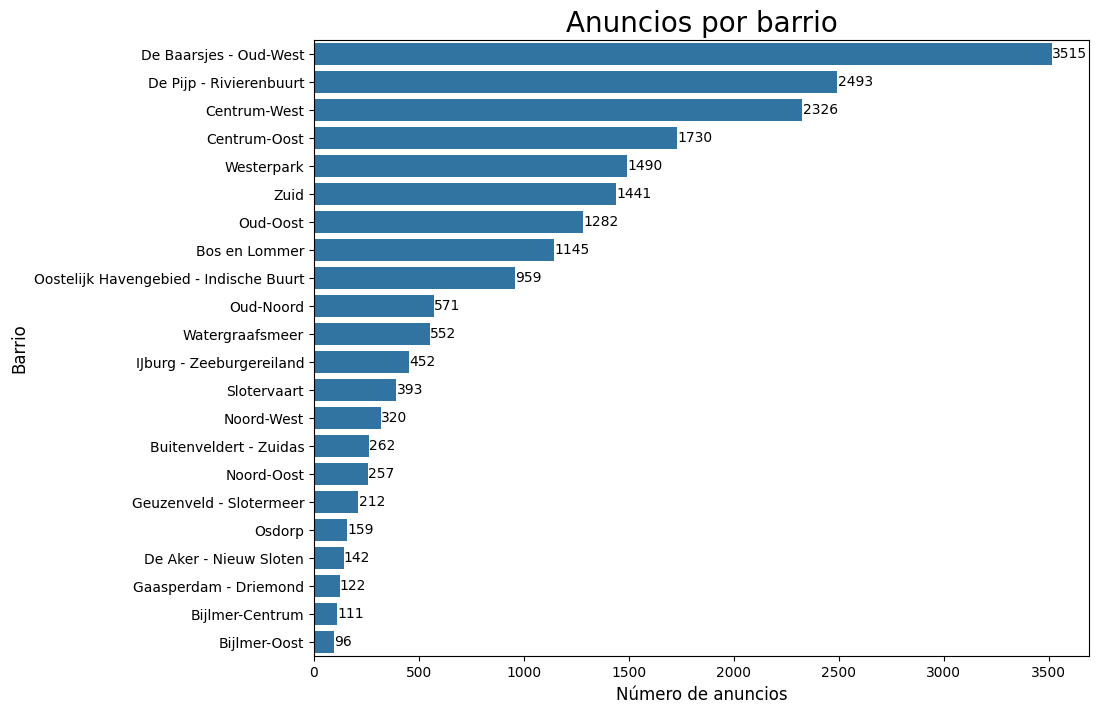

In [14]:
# Datos
feq = listings['neighbourhood'].value_counts().sort_values(ascending=False)

# Configuración de Seaborn para un gráfico de barras horizontal
plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x=feq.values,  # Frecuencias (eje x)
    y=feq.index,   # Barrios (eje y, porque es horizontal)
    # Color de las barras
)

# Agregar valores a cada barra
for index, value in enumerate(feq.values):
    plt.text(
        value + 1,  # Desplazar el texto ligeramente hacia la derecha
        index,      # Posición en el eje y
        str(value), # Convertir el valor en texto
        va='center', ha='left', fontsize=10  # Alinear el texto
    )

# Títulos y etiquetas
plt.title("Anuncios por barrio", fontsize=20)
plt.xlabel("Número de anuncios", fontsize=12)
plt.ylabel("Barrio", fontsize=12)

# Mostrar el gráfico
plt.show()

Abajo puede ver que la mayoría de los anuncios están en el centro de la ciudad. Este mapa es interactivo, y se puede hacer zoom en los grupos para encontrar finalmente las ubicaciones individuales de los listados.

In [15]:
lats2018 = listings['latitude'].tolist()
lons2018 = listings['longitude'].tolist()
locations = list(zip(lats2018, lons2018))

map1 = folium.Map(location=[52.3680, 4.9036], zoom_start=11.5)   # Crea un mapa centrado en Ámsterdam(Esas son sus coordenadas) con nivel de zoom 11.5.

FastMarkerCluster(data=locations).add_to(map1) # Crea un clúster de marcadores con las coordenadas y lo agrega al mapa.
map1


### Tipos de habitación
El tipo de habitación es muy importante en Ámsterdam, ya que esta ciudad tiene una norma según la cual las casas/apartamentos enteros solo pueden alquilarse a través de Airbnb durante un máximo de 60 días al año. A continuación, podemos ver que esta restricción se aplica a la mayoría de los listados.

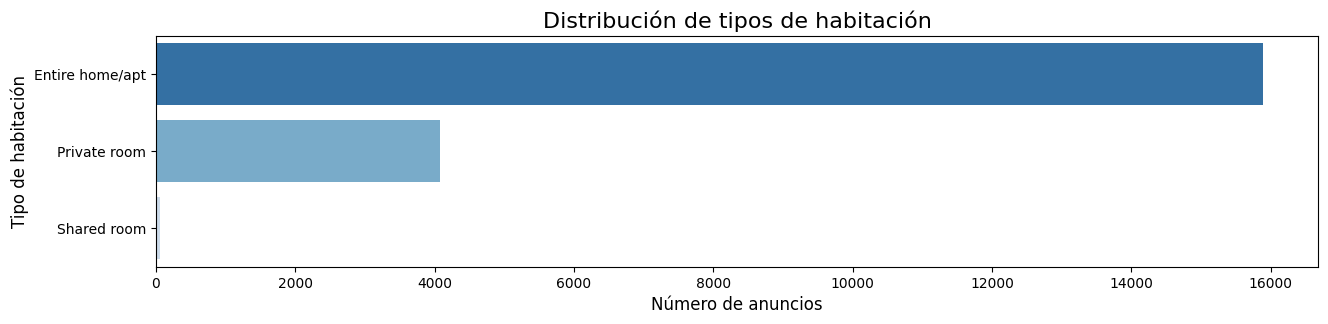

In [16]:
# Obtener la frecuencia de cada tipo de habitación
freq = listings['room_type'].value_counts().sort_values(ascending=False)

# Crear el gráfico de barras horizontal
plt.figure(figsize=(15, 3))  # Tamaño del gráfico
sns.barplot(x=freq.values, y=freq.index, palette="Blues_r")  # Gráfico con valores en x e índices en y
plt.title("Distribución de tipos de habitación", fontsize=16)  # Título
plt.xlabel("Número de anuncios", fontsize=12)  # Etiqueta eje X
plt.ylabel("Tipo de habitación", fontsize=12)  # Etiqueta eje Y
plt.show()

### Tipos de propiedad
En el conjunto de datos, encontramos muchos tipos de propiedad diferentes.

In [17]:
listings['property_type'].unique()

array(['Apartment', 'Townhouse', 'Houseboat', 'Bed and breakfast', 'Boat',
       'Guest suite', 'Loft', 'Serviced apartment', 'House',
       'Boutique hotel', 'Guesthouse', 'Other', 'Condominium', 'Chalet',
       'Nature lodge', 'Tiny house', 'Hotel', 'Villa', 'Cabin',
       'Lighthouse', 'Bungalow', 'Hostel', 'Cottage', 'Tent',
       'Earth house', 'Campsite', 'Castle', 'Camper/RV', 'Barn',
       'Casa particular (Cuba)', 'Aparthotel'], dtype=object)

Sin embargo, muchos de esos tipos de inmuebles tienen muy pocos anuncios en Ámsterdam. En la siguiente figura, sólo muestro los tipos de inmuebles con al menos 100 anuncios. Como podemos ver, la gran mayoría de las propiedades en Ámsterdam son apartamentos.

In [18]:
prop = listings.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=100]
prop = prop.drop(columns=['total'])
prop

room_type,Entire home/apt,Private room,Shared room
property_type,,,
Guest suite,36.0,116.0,NaN
Houseboat,154.0,69.0,2.0
Condominium,252.0,69.0,2.0
Boat,257.0,113.0,2.0
Loft,319.0,63.0,2.0
Bed and breakfast,23.0,426.0,6.0
Townhouse,477.0,168.0,4.0
House,1159.0,361.0,3.0
Apartment,12990.0,2550.0,42.0


In [19]:
prop_long = prop.reset_index().melt(id_vars='property_type', var_name='room_type', value_name='count').sort_values(by=['count'], ascending=False)
prop_long

,property_type,room_type,count
8,Apartment,Entire home/apt,12990.0
17,Apartment,Private room,2550.0
7,House,Entire home/apt,1159.0
6,Townhouse,Entire home/apt,477.0
14,Bed and breakfast,Private room,426.0
16,House,Private room,361.0
4,Loft,Entire home/apt,319.0
3,Boat,Entire home/apt,257.0
2,Condominium,Entire home/apt,252.0
15,Townhouse,Private room,168.0


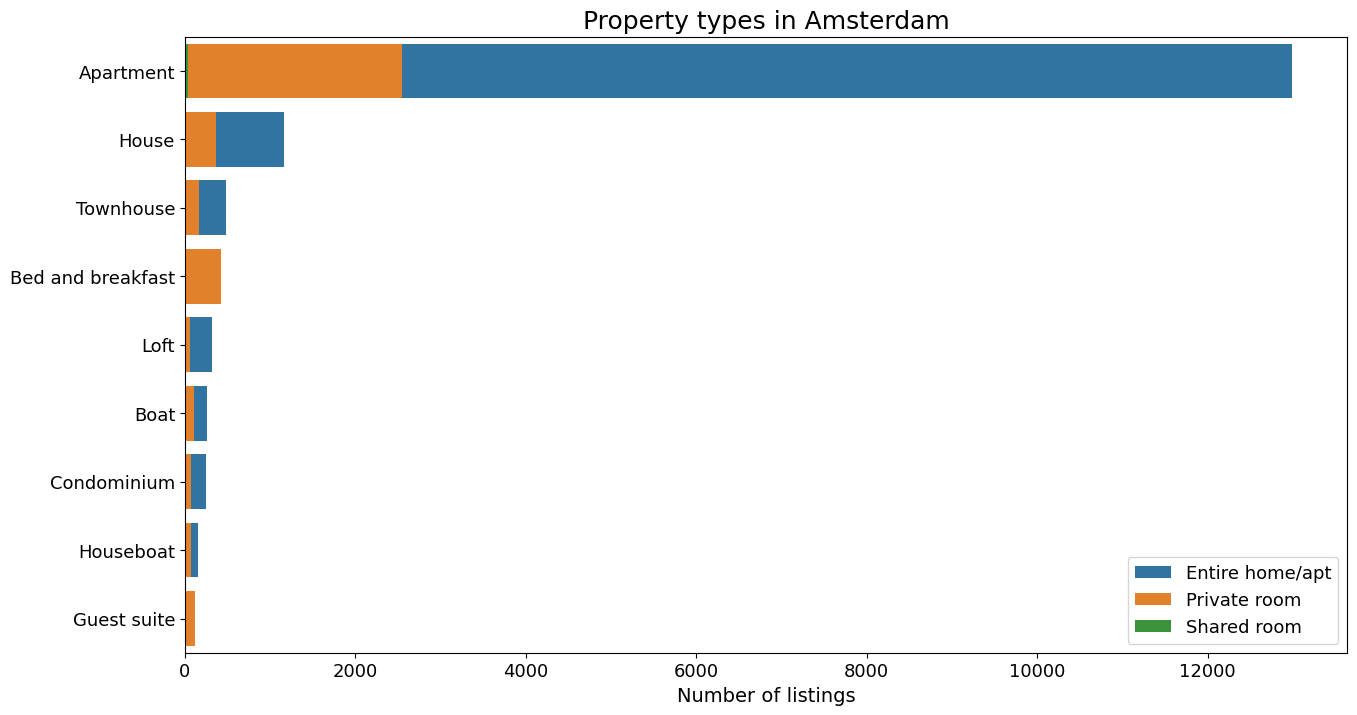

In [20]:

# Crear gráfico apilado
plt.figure(figsize=(15, 8))
sns.barplot(data=prop_long, x='count', y='property_type', hue='room_type', dodge=False)

# Personalización del gráfico
plt.title('Property types in Amsterdam', fontsize=18)
plt.xlabel('Number of listings', fontsize=14)
plt.ylabel("")
plt.legend(loc=4, fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Mostrar el gráfico
plt.show()


## 2.3 Alojamiento (número de personas)
Como era de esperar, la mayoría de los anuncios son para 2 personas. Además, Airbnb utiliza un máximo de 16 huéspedes por anuncio.

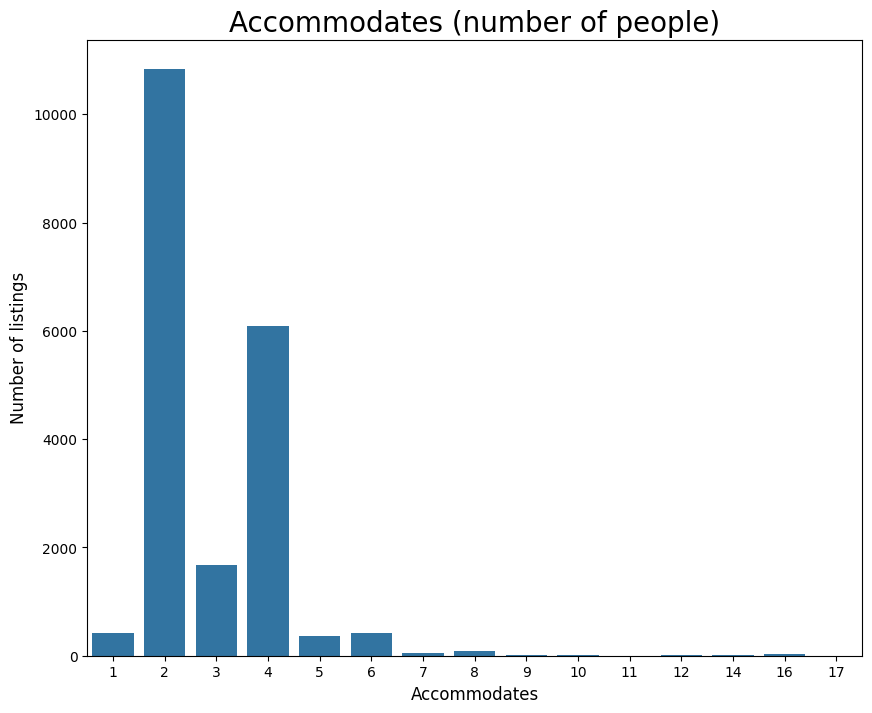

In [21]:
# Datos a graficar (suponiendo que 'listings' es tu DataFrame)
feq = listings['accommodates'].value_counts().sort_index()

# Convertir los datos a un DataFrame para usar con seaborn
accommodates_df = feq.reset_index()
accommodates_df.columns = ['Accommodates', 'Number of listings']

# Crear el gráfico de barras
plt.figure(figsize=(10, 8))
sns.barplot(x='Accommodates', y='Number of listings', data=accommodates_df)
# Personalización del gráfico
plt.title("Accommodates (number of people)", fontsize=20)
plt.xlabel('Accommodates', fontsize=12)
plt.ylabel('Number of listings', fontsize=12)

# Mostrar el gráfico
plt.show()


Sin embargo, Ámsterdam tiene una restricción adicional. Debido a consideraciones de riesgo de incendio y también teniendo en cuenta posibles grupos ruidosos, a los propietarios sólo se les permite alquilar su propiedad a grupos con un máximo de 4 personas. Esto significa que los anuncios que indican que el número máximo de personas es superior a 4 están infringiendo esta norma.

# Consejos al ayuntamiento de Ámsterdam

Es sabido que Airbnb causa problemas en Ámsterdam. Estos problemas se describen bien en este artículo: [Fed Up With Tourists, Amsterdam Gets Tough On Airbnb, Tourist Taxes And Too Much Partying](https://www.forbes.com/sites/ceciliarodriguez/2018/05/17/amsterdam-overwhelmed-by-tourists-gets-tough-on-airbnb-tourists-taxes-too-much-partying/#5c6c78892be5)

>La coalición de partidos que forma el nuevo gobierno de la ciudad quiere seguir los ejemplos de Barcelona y Venecia, donde la avalancha de turismo descontrolado ha hecho la vida extremadamente desagradable a los residentes, obligando a los funcionarios a intentar controlar el número de visitantes y su comportamiento.

Las normas adicionales que Ámsterdam tiene en vigor en comparación con las propias normas de Airbnb son:

* El número máximo de huéspedes es de 4 (véase también la sección anterior).
* El número máximo de alquileres a corto plazo es de 60 días por año natural. Esta norma sólo se aplica al alquiler de propiedades enteras, por lo que no se aplica al alquiler de habitaciones privadas. Esta norma ya la aplicaba Airbnb (tras 60 días de reservas, Airbnb cierra la disponibilidad del anuncio para el resto del año). Como se puede leer en el artículo, el número se reducirá a un máximo de 30 días al año.
* Ámsterdam pretende prohibir Airbnb por completo en tres barrios: de Wallen (Barrio Rojo), Kinkerbuurt y Haarlemmerbuurt.
* Para el alquiler de habitaciones privadas, también existe la restricción de que un propietario no puede alquilar habitaciones que acumulen más de 30 días al año.


In [22]:
private = listings[listings['room_type'] == "Private room"]
host_private = private.groupby(['host_id', 'host_name', 'street']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)
host_private.head()

,host_id,host_name,street,private_rooms
2436,67005410,Feliciano,"Amsterdam, Noord-Holland, Netherlands",15
918,10076897,Geraldine,"Amsterdam, Noord-Holland, Netherlands",13
2113,44168250,Ruben,"Amsterdam, Noord-Holland, Netherlands",13
3209,174174070,Amrath,"Badhoevedorp, Badhoevedorp, Netherlands",7
1570,22879651,Wamme,"Amsterdam, Noord-Holland, Netherlands",7


Sin embargo, tenemos las coordenadas GPS de los anuncios. A mí me parece muy probable que todas las habitaciones privadas que ofrece el anfitrión Feliciano estén de hecho en el mismo edificio (sólo pequeñas variaciones de latitud/longitud). Aunque este anfitrión podría tener una licencia de hotel, sus anuncios me parecen sospechosos (¿cuál es el nombre del hotel?). Aconsejaría al ayuntamiento de Amsterdam que comprobara si en este caso no se infringe ninguna norma.

In [23]:
feliciano = private[private['host_id']== 67005410]
feliciano = feliciano[['name','host_id', 'host_name', 'latitude', 'longitude']]
feliciano.index.name = "listing_id"
feliciano

,name,host_id,host_name,latitude,longitude
listing_id,,,,,
12392592,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.375251,4.900321
12444222,Hotel in the heart of Amsterdam 4p,67005410,Feliciano,52.375130,4.899694
12446710,Hotel in the heart of Amsterdam 3p,67005410,Feliciano,52.374695,4.900266
12451293,"Hotel in the heart of Amsterdam, Single room",67005410,Feliciano,52.374682,4.898916
12579177,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.374567,4.898310
12582071,Hotel in the heart of Amsterdam 3p,67005410,Feliciano,52.373407,4.900022
12865293,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.375077,4.900191
12865495,Hotel in the heart of Amsterdam 2p,67005410,Feliciano,52.373396,4.898427
12898673,Hotel in the heart of Amsterdam 1p,67005410,Feliciano,52.373346,4.898344


## ¿Efectos indeseados de los anfitriones profesionales?
Por el momento, Ámsterdam no cuenta con ninguna norma que impida las actividades de alojamiento profesional. Me imagino que tener la opción de subcontratar estas actividades conduce a un mayor número de listados. Por el momento, alrededor del 75% de los anfitriones sólo tienen un anuncio. Supongo que los anfitriones que sólo tienen un par de anuncios son probablemente los anfitriones de un par de amigos. Sin embargo, vemos que hay casos extremos. Creo que es poco probable que los anfitriones con más de 10 anuncios lo hagan sólo para sí mismos y para sus amigos y familiares.

In [24]:
freq = listings.groupby(['host_id']).size().reset_index(name='num_host_listings')
host_prop = freq.groupby(['num_host_listings']).size().reset_index(name='count').transpose()
host_prop.columns = host_prop.iloc[0]
host_prop = host_prop.drop(host_prop.index[0])
host_prop

num_host_listings,1,2,3,4,5,6,7,8,9,10,...,19,21,24,25,27,30,38,83,105,208
count,15830,1104,174,50,37,24,9,6,4,3,...,2,2,1,1,1,1,1,1,1,1


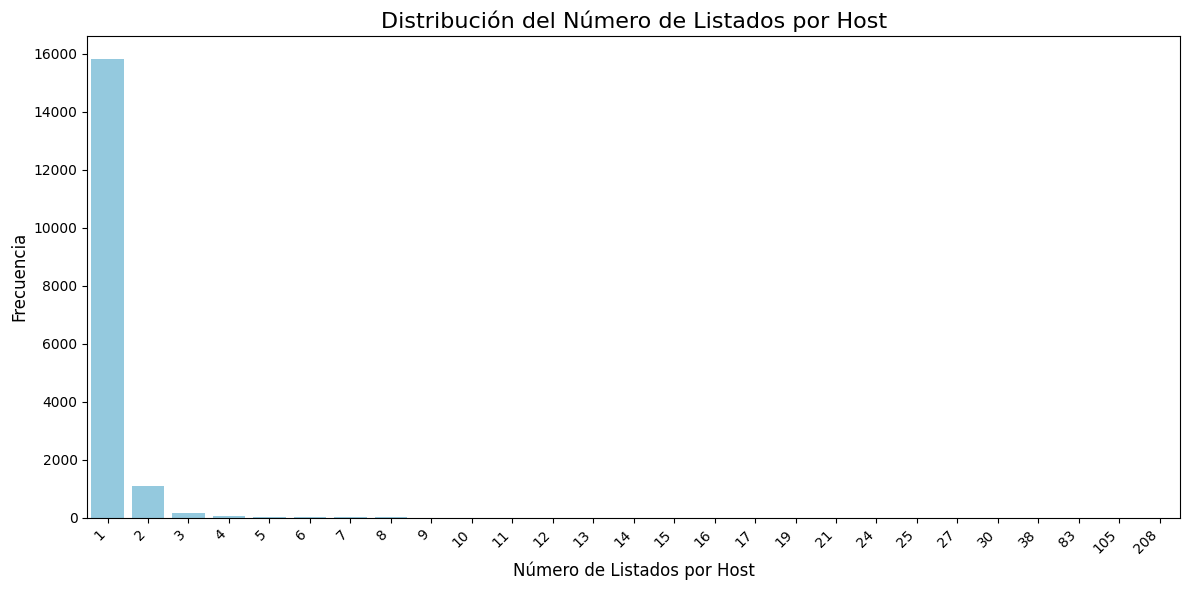

In [25]:


# Asegurarse de que el DataFrame tiene las columnas correctas
host_prop = host_prop.transpose().reset_index()
host_prop.columns = ['num_host_listings', 'count']

# Graficar con seaborn (gráfico de barras)
plt.figure(figsize=(12, 6))
sns.barplot(data=host_prop, x='num_host_listings', y='count', color='skyblue')

# Títulos y etiquetas
plt.title('Distribución del Número de Listados por Host', fontsize=16)
plt.xlabel('Número de Listados por Host', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)

# Ajustar el tamaño de los valores del eje X y Y
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Mostrar el gráfico
plt.show()


A continuación, muestro los hosts con más de 20 listados. Lamentablemente, el host_about no se ha extraído en su totalidad. Sin embargo, como este conjunto de datos es muy reciente, no me resultó difícil encontrar la descripción del anfitrión con más de 200 anuncios en airbnb.com. Como puede ver, este anfitrión es claramente un anfitrión profesional.

Como probablemente sea difícil aplicar y controlar una medida que prohíba por completo las actividades de alojamiento profesional, aconsejaría al municipio de Ámsterdam que considerara la posibilidad de establecer un número máximo de anuncios por anfitrión. Si Ámsterdam lo fijara, por ejemplo, en 10 (y consiguiera implementarlo en los sistemas de Airbnb), sería mucho más difícil explotar el alojamiento en Airbnb como actividad profesional.

In [26]:
freq = listings.groupby(['host_id', 'host_name', 'host_about']).size().reset_index(name='num_host_listings')
freq = freq.sort_values(by=['num_host_listings'], ascending=False)
freq = freq[freq['num_host_listings'] >= 20]
freq

,host_id,host_name,host_about,num_host_listings
8166,65859990,Martijn,"Hi, I'm Martijn, \r\n\r\nWe are a team of prof...",208
535,1464510,Michiel And Jane,"Hi, we are Michiel & Jane,\r\n\r\nWe are a tea...",105
8999,113977564,Willem,I own a hotel in Amsterdam and manage properti...,38
190,517215,Niels En Viv (Welcome Back),"Hi travellers, \r\n\r\nWe are Welcome Back, a ...",30
4935,14183886,Luis,We are Luis and Melanie and we managed our own...,25
4531,11969034,Raul,"Dear Guests,\r\n\r\nI'm Raul, 35 years old. I ...",24
7456,44168250,Ruben,Running a family business in real estate & tou...,21
3457,7594884,"Ruben, Sarah & Lindy","We are Ruben, Sarah & Lindy, we rent out prope...",21


In [28]:
# Extraer un host_about cualquiera (por ejemplo, el de Martijn)
host_about_example = freq.loc[8166, 'host_about']

host_about_example = host_about_example.replace("\r\n", "\n")

# Imprimir en formato Markdown
print(f"## Host About :\n\n{host_about_example}")

## Host About :

Hi, I'm Martijn, 

We are a team of professional hosts established by travelers just like you. We believe in sharing homes. Wherever you are, it is delightful to explore and discover an unknown city from an authentic home. 

On behalf of home owners we advertise their properties through our airbnb profile and support them by offering you a pleasant stay. 

When you book your holiday with us, you can be confident of a memorable stay and an experience through the eyes of a local. We are more than happy to share our knowledge, give you the best insider tips and recommendations about Amsterdam.

If you have any questions, holiday wishes or simply want to have a chat, then feel free to contact us any time. We always reply within an hour!

We look forward to being your host! :)


# Consejos a los turistas
##  Precio medio diario por barrio
Para comparar «manzanas con manzanas» sólo he seleccionado el tipo de alojamiento más común, que es el alojamiento para 2 personas. Como era de esperar, el alojamiento en el centro de la ciudad es el más caro. 

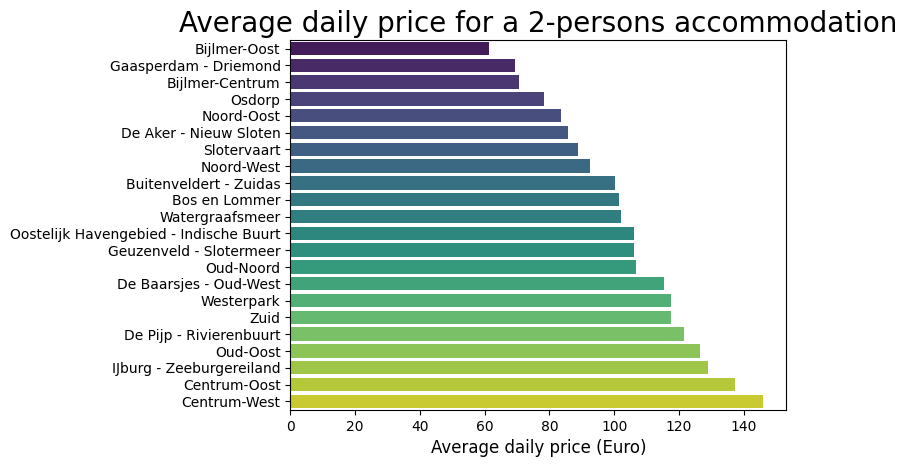

In [29]:
# Filtrar el DataFrame para obtener solo aquellos con 'accommodates' igual a 2
feq = listings[listings['accommodates'] == 2]

# Calcular el precio promedio por barrio
feq = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)

# Crear el gráfico con seaborn
sns.barplot(x=feq.values, y=feq.index,palette='viridis')

# Agregar títulos y etiquetas
plt.title("Average daily price for a 2-persons accommodation", fontsize=20)
plt.xlabel('Average daily price (Euro)', fontsize=12)
plt.ylabel("", fontsize=12)
plt.yticks(fontsize=10)
# Mostrar el gráfico
plt.show()


A continuación encontrará los barrios en un mapa. Este mapa es **interactivo**. Al pasar el ratón por encima de los polígonos se muestra el nombre del barrio y el precio medio del alojamiento para 2 personas.

In [ ]:
adam = gpd.read_file("input/neighbourhoods.geojson")
feq = pd.DataFrame([feq])
feq = feq.transpose()
adam = pd.merge(adam, feq, on='neighbourhood', how='left')
adam.rename(columns={'price': 'average_price'}, inplace=True)
adam.average_price = adam.average_price.round(decimals=0)

map_dict = adam.set_index('neighbourhood')['average_price'].to_dict()
color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

def get_color(feature):
    value = map_dict.get(feature['properties']['neighbourhood'])
    return color_scale(value)

map3 = folium.Map(location=[52.3680, 4.9036], zoom_start=11)
folium.GeoJson(data=adam,
               name='Amsterdam',
               tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
                                                      labels=True,
                                                      sticky=False),
               style_function= lambda feature: {
                   'fillColor': get_color(feature),
                   'color': 'black',
                   'weight': 1,
                   'dashArray': '5, 5',
                   'fillOpacity':0.5
                   },
               highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map3)
map3

## Seguridad vecinal
Como no hay datos sobre la seguridad de los barrios en los archivos de Airbnb, los he buscado en Internet y he encontrado el siguiente mapa. Como se puede ver, actualmente las zonas occidentales de la ciudad son las más peligrosas.

Nota personal: Al parecer, «de Bijlmer» (las zonas del sudeste) son razonablemente seguras hoy en día. Sin embargo, hace años conocí a alguien que vivía allí como estudiante. En aquella época no era un buen barrio, y me advirtieron que no me metiera debajo de los balcones porque la gente podía tirar basura y muebles viejos. Recibir un viejo sofá en la cabeza no sonaba como la cosa más agradable del mundo ;-).

<center><img src=«https://i.imgur.com/7cso9GD.png» style=«width: 800px;»/></center>

## Puntuación de las opiniones sobre la ubicación y puntuación de la ubicación en función del precio
En esta sección, agrupo las puntuaciones de las opiniones sobre la ubicación por barrios (sólo anuncios con al menos 10 opiniones). Aunque espero que la distancia al centro de la ciudad sea un factor importante, estas puntuaciones también deberían tener en cuenta otros aspectos. Otros factores pueden ser:

* La seguridad de una ubicación (como se muestra en la sección anterior).
* El ruido. Si un anuncio está situado en el centro, pero rodeado de bares ruidosos, eso debería costar puntos en la puntuación de la valoración de la ubicación.
* Si un anuncio está situado fuera del centro de la ciudad pero bien comunicado por transporte público, debería obtener puntos extra por ello.
* Instalaciones cerca del anuncio. ¿Hay supermercados, bares y restaurantes cerca?
* Algunas personas pueden estar buscando aparcamiento gratuito si vienen en coche (el aparcamiento es muy caro en Amsterdam en general).

A continuación vemos que los barrios céntricos, que por lo general también eran los más caros, también suelen tener una puntuación más alta en la valoración de la ubicación.  Si calculara la distancia al centro de la ciudad de cada anuncio, esperaría ver correlaciones bastante fuertes entre esta distancia y el precio y la puntuación de la ubicación.

Al mirar la puntuación media de las opiniones, me sorprende ver que la media es superior a 8/10 en todos los barrios. Sé que Ámsterdam es una ciudad pequeña (mucho más pequeña de lo que mucha gente piensa). Por lo tanto, no se tarda mucho tiempo en llegar al centro de la ciudad desde cualquier lugar, lo que podría

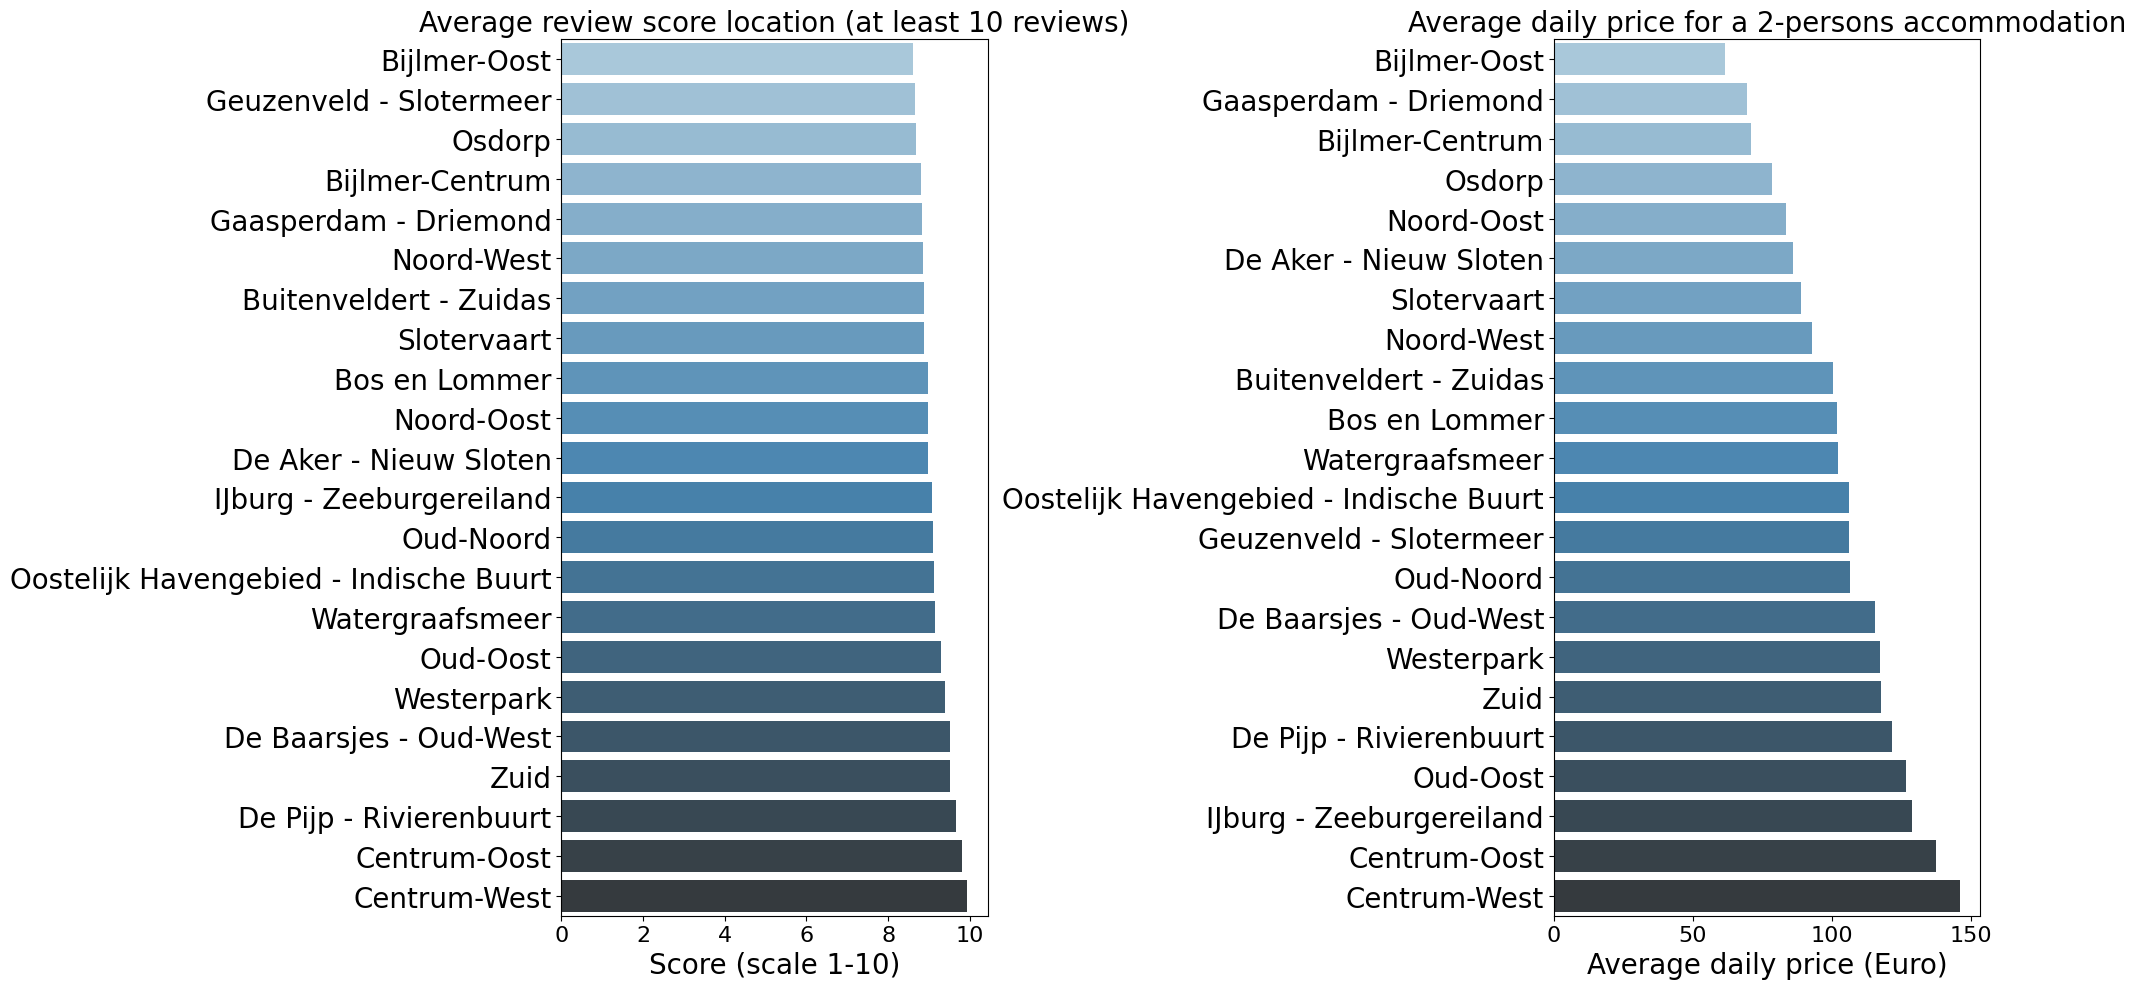

In [31]:

# Configuración de la figura y tamaños de las etiquetas
fig = plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

# Primer gráfico: Promedio de review_scores_location para al menos 10 reseñas
ax1 = fig.add_subplot(121)
feq = listings[listings['number_of_reviews'] >= 10]
feq1 = feq.groupby('neighbourhood')['review_scores_location'].mean().sort_values(ascending=True)

# Usamos seaborn.barplot para crear el gráfico horizontal
sns.barplot(x=feq1.values, y=feq1.index, ax=ax1, palette="Blues_d")

ax1.set_title("Average review score location (at least 10 reviews)", fontsize=20)
ax1.set_xlabel('Score (scale 1-10)', fontsize=20)
ax1.set_ylabel("")

# Segundo gráfico: Promedio de precio para acomodar 2 personas
ax2 = fig.add_subplot(122)
feq = listings[listings['accommodates'] == 2]
feq2 = feq.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)

# Usamos seaborn.barplot para crear el gráfico horizontal
sns.barplot(x=feq2.values, y=feq2.index, ax=ax2, palette="Blues_d")

ax2.set_title("Average daily price for a 2-persons accommodation", fontsize=20)
ax2.set_xlabel('Average daily price (Euro)', fontsize=20)
ax2.set_ylabel("")

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
plt.show()


## Cómo utilizar las puntuaciones de las opiniones
Además de las opiniones escritas, los huéspedes pueden enviar una puntuación general por estrellas y un conjunto de puntuaciones por estrellas de categorías. Los huéspedes pueden dar puntuaciones sobre:

* Experiencia general. ¿Cuál fue su experiencia general?
* Limpieza. ¿Sintió que su espacio estaba limpio y ordenado?
* Precisión. ¿Hasta qué punto la página del anuncio representaba correctamente su espacio?
* Valor. ¿Considera que su anuncio ofrece una buena relación calidad-precio?
* Comunicación. ¿Cómo de bien te comunicaste con tu anfitrión antes y durante su estancia?
* Llegada. ¿Cómo fue el check-in?
* Ubicación. ¿Qué le pareció el barrio?

A continuación puede ver la distribución de las puntuaciones de todas esas categorías. Lo que me llamó la atención de inmediato es que las puntuaciones parecen muy altas en todos los ámbitos. Una rápida búsqueda en Internet me dijo que esto parece común en Airbnb. Se explica bien en este artículo: [El 95% de los alojamientos de Airbnb tienen una puntuación de 4,5 a 5 estrellas](https://mashable.com/2015/02/25/airbnb-reviews-above-average/?europe=true#1YLfzOC34sqd).

Después de haber visto las distribuciones de las puntuaciones, personalmente consideraría que cualquier puntuación de 8 o inferior no es una buena puntuación. Si quisiera utilizar cualquiera de estas puntuaciones en una búsqueda de alojamiento, creo que la de «Valor» parece la más útil. En primer lugar, siempre me gusta obtener una buena relación calidad-precio ;-). Sin embargo, el número de «10 medias» es razonablemente pequeño, lo que hace que el indicador sea un poco más «distinguible» que otros indicadores.

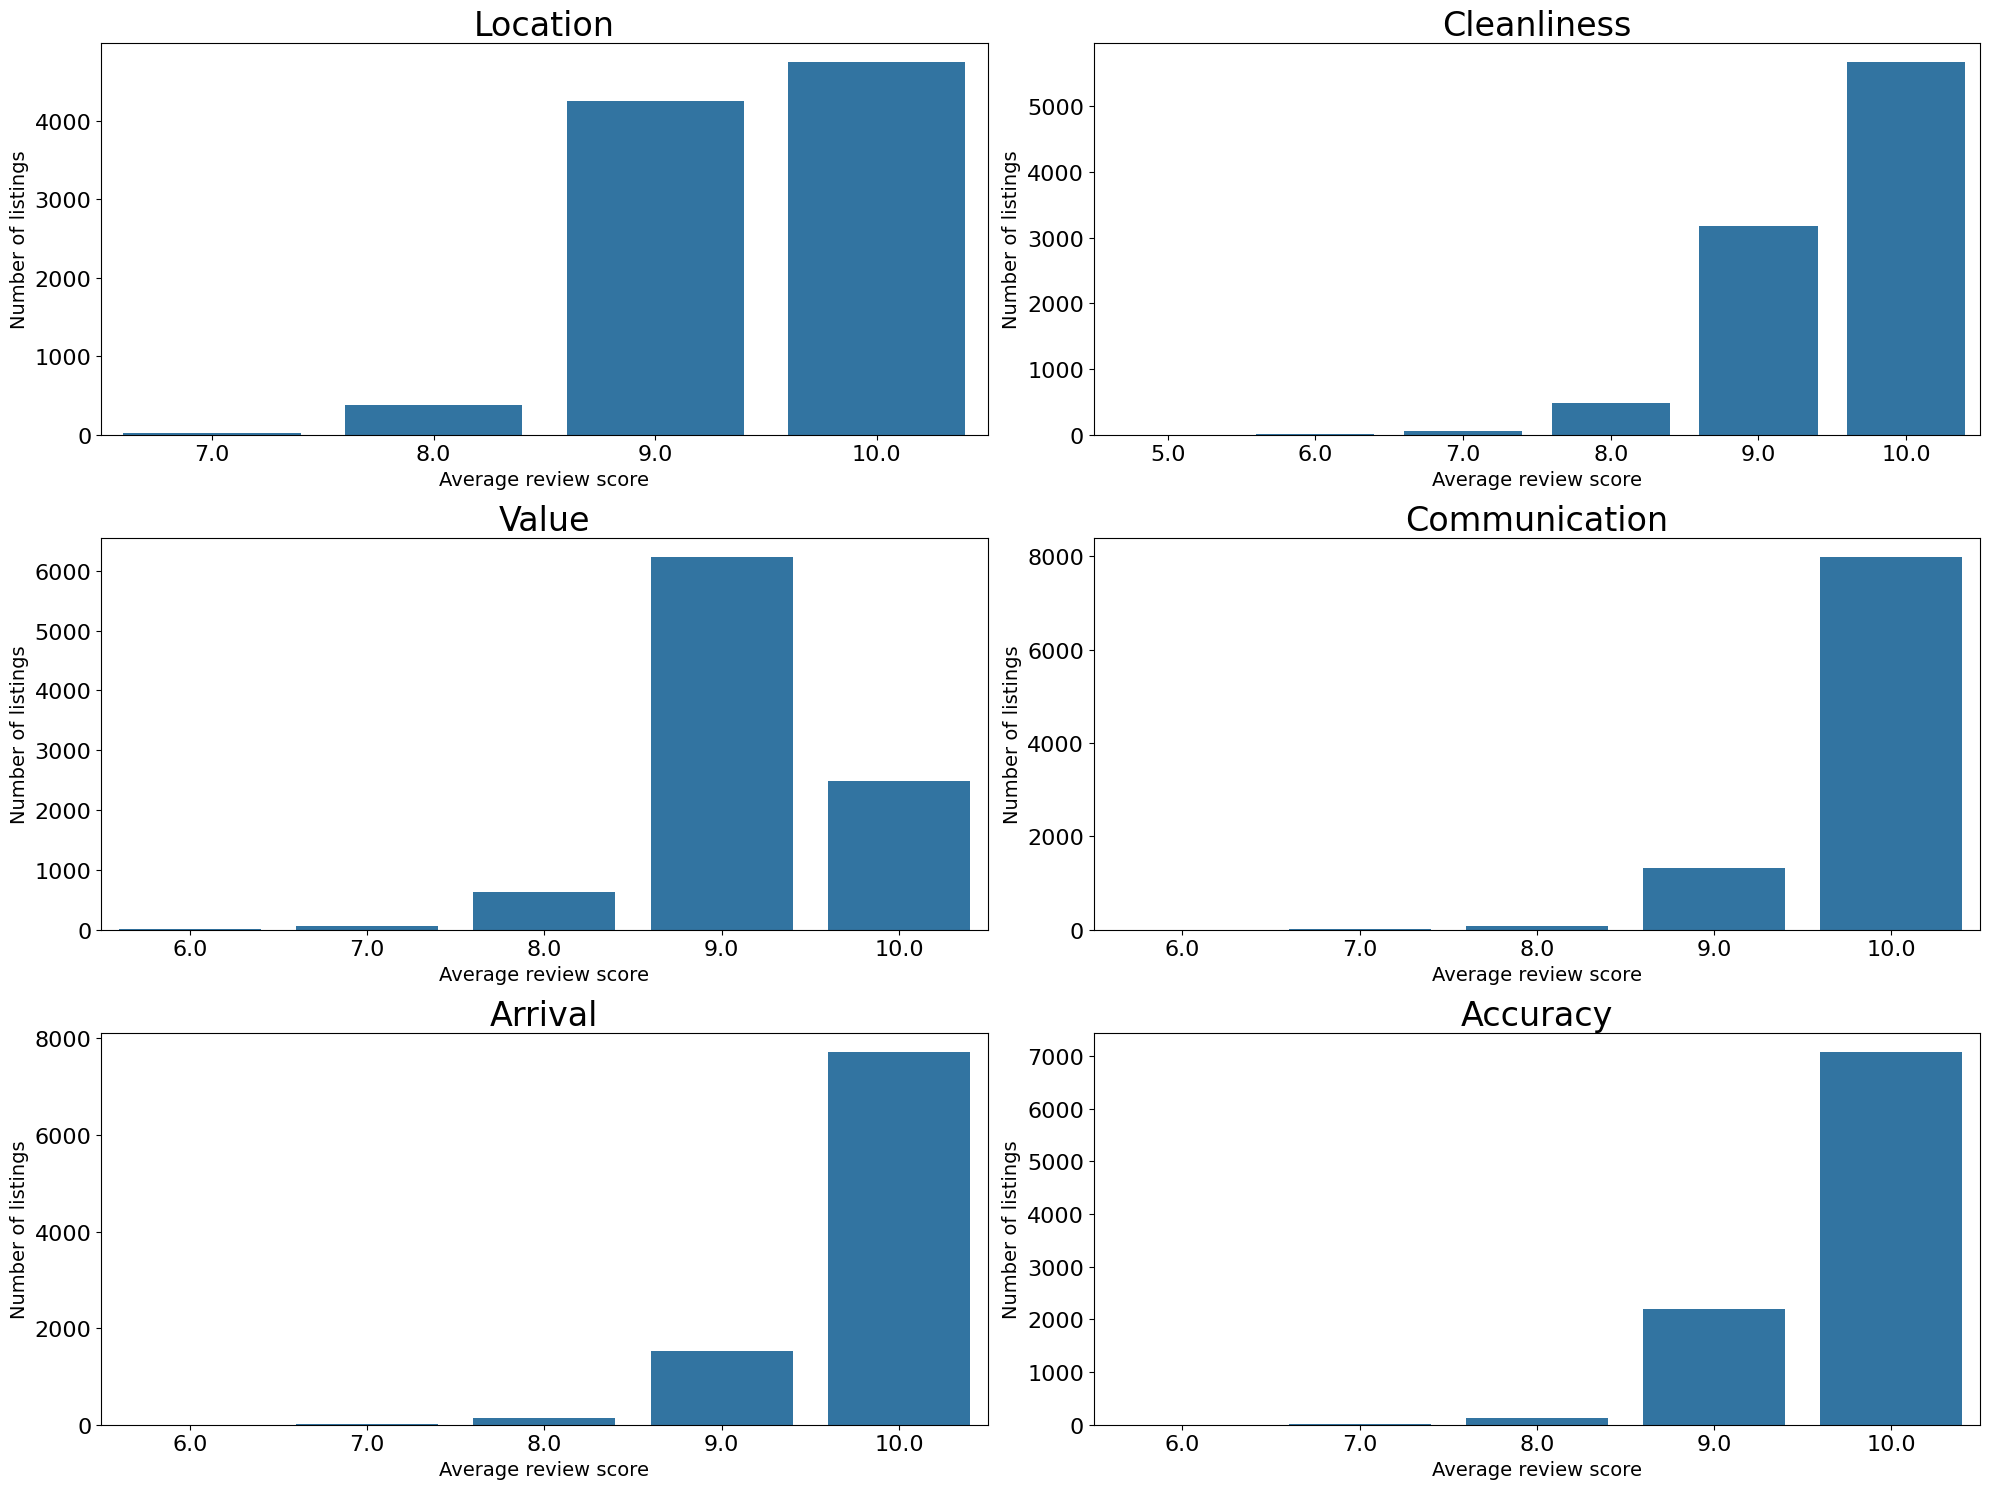

In [32]:
# Filtramos el dataframe
listings10 = listings[listings['number_of_reviews'] >= 10]

# Configuración de la figura y tamaños de las etiquetas
fig = plt.figure(figsize=(20, 15))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

# Primer gráfico: Location
ax1 = fig.add_subplot(321)
feq = listings10['review_scores_location'].value_counts().sort_index()
sns.barplot(x=feq.index, y=feq.values, ax=ax1, )
ax1.set_title("Location", fontsize=24)
ax1.set_ylabel('Number of listings', fontsize=14)
ax1.set_xlabel('Average review score', fontsize=14)

# Segundo gráfico: Cleanliness
ax2 = fig.add_subplot(322)
feq = listings10['review_scores_cleanliness'].value_counts().sort_index()
sns.barplot(x=feq.index, y=feq.values, ax=ax2, )
ax2.set_title("Cleanliness", fontsize=24)
ax2.set_ylabel('Number of listings', fontsize=14)
ax2.set_xlabel('Average review score', fontsize=14)

# Tercer gráfico: Value
ax3 = fig.add_subplot(323)
feq = listings10['review_scores_value'].value_counts().sort_index()
sns.barplot(x=feq.index, y=feq.values, ax=ax3, )
ax3.set_title("Value", fontsize=24)
ax3.set_ylabel('Number of listings', fontsize=14)
ax3.set_xlabel('Average review score', fontsize=14)

# Cuarto gráfico: Communication
ax4 = fig.add_subplot(324)
feq = listings10['review_scores_communication'].value_counts().sort_index()
sns.barplot(x=feq.index, y=feq.values, ax=ax4, )
ax4.set_title("Communication", fontsize=24)
ax4.set_ylabel('Number of listings', fontsize=14)
ax4.set_xlabel('Average review score', fontsize=14)

# Quinto gráfico: Arrival
ax5 = fig.add_subplot(325)
feq = listings10['review_scores_checkin'].value_counts().sort_index()
sns.barplot(x=feq.index, y=feq.values, ax=ax5, )
ax5.set_title("Arrival", fontsize=24)
ax5.set_ylabel('Number of listings', fontsize=14)
ax5.set_xlabel('Average review score', fontsize=14)

# Sexto gráfico: Accuracy
ax6 = fig.add_subplot(326)
feq = listings10['review_scores_accuracy'].value_counts().sort_index()
sns.barplot(x=feq.index, y=feq.values, ax=ax6, )
ax6.set_title("Accuracy", fontsize=24)
ax6.set_ylabel('Number of listings', fontsize=14)
ax6.set_xlabel('Average review score', fontsize=14)

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()


## Encontrar un buen anfitrión
En Airbnb puedes obtener el estatus de «Superanfitrión». De Airbnb:
* Como Superanfitrión, tendrás más visibilidad, potencial de ganancias y recompensas exclusivas. Es nuestra forma de agradecerle su extraordinaria hospitalidad.
* Cómo convertirse en Superanfitrión: Cada 3 meses, comprobamos si cumple los siguientes criterios. Si los cumples, ganarás o mantendrás tu estatus de Superanfitrión.
    * Los Superanfitriones tienen una puntuación media general de 4,8 o superior basada en las opiniones de al menos el 50% de sus huéspedes de Airbnb en el último año. 
    * Los Superanfitriones han alojado al menos 10 estancias en el último año o, si alojan reservas de larga duración, 100 noches durante al menos 3 estancias. 
    * Los Superanfitriones no han tenido cancelaciones en el último año, a no ser que haya habido circunstancias atenuantes.
    * Los superanfitriones responden al 90% de los mensajes nuevos en un plazo de 24 horas.

Abajo, podemos ver que sólo una pequeña parte de los listados en Amsterdam tienen un anfitrión que es Superanfitrión.7

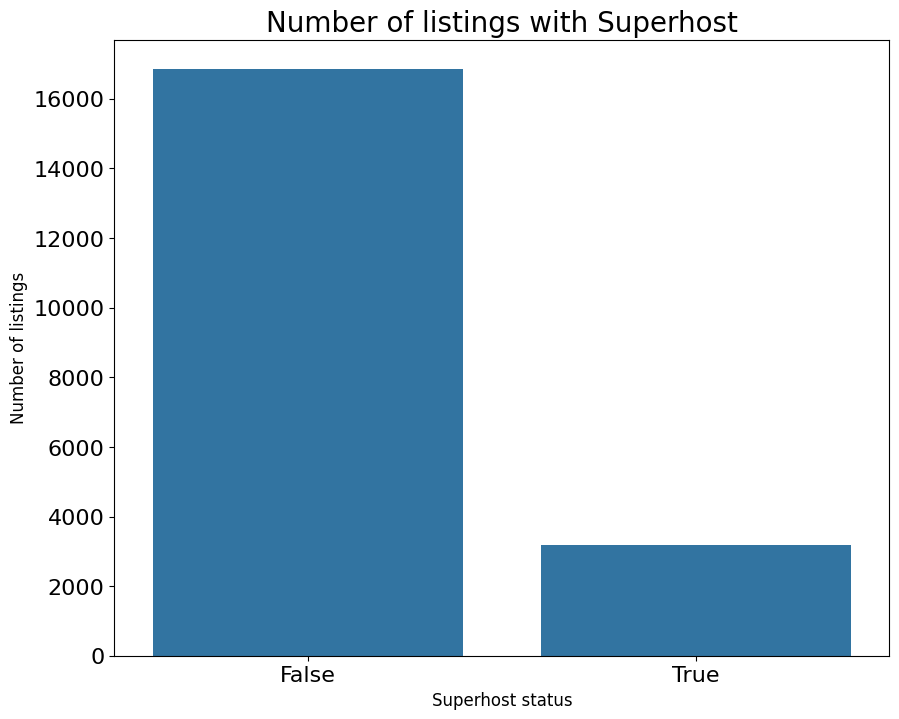

In [33]:
# Reemplazamos los valores de 'host_is_superhost' para que tengan formato True/False
listings.host_is_superhost = listings.host_is_superhost.replace({"t": "True", "f": "False"})

# Contamos la frecuencia de los valores en 'host_is_superhost'
feq = listings['host_is_superhost'].value_counts()

# Creamos el gráfico de barras con seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x=feq.index, y=feq.values,)

# Títulos y etiquetas
plt.title("Number of listings with Superhost", fontsize=20)
plt.ylabel('Number of listings', fontsize=12)
plt.xlabel('Superhost status', fontsize=12)

# Mostramos el gráfico
plt.show()


Si tuviera que reservar alojamiento, no buscaría necesariamente un superalojamiento. En realidad, tendría miedo de pagar demasiado, ya que es probable que los superanfitriones aumenten sus precios. Sin embargo, tampoco querría un anfitrión que responda mal o cancele mucho.

Como podemos ver, más de 5.000 de los 20.000 listados tienen al menos 10 opiniones y responden al menos al 90% de los mensajes nuevos. Yo consideraría a esos anfitriones «probados» como buenos respondedores (lo que no significa que un anuncio con menos de 10 valoraciones no pueda tener anfitriones que respondan bien; simplemente no está probado todavía). Además, hay muy pocos anuncios en los que los anfitriones no respondan a los nuevos mensajes en un plazo de 24 horas.

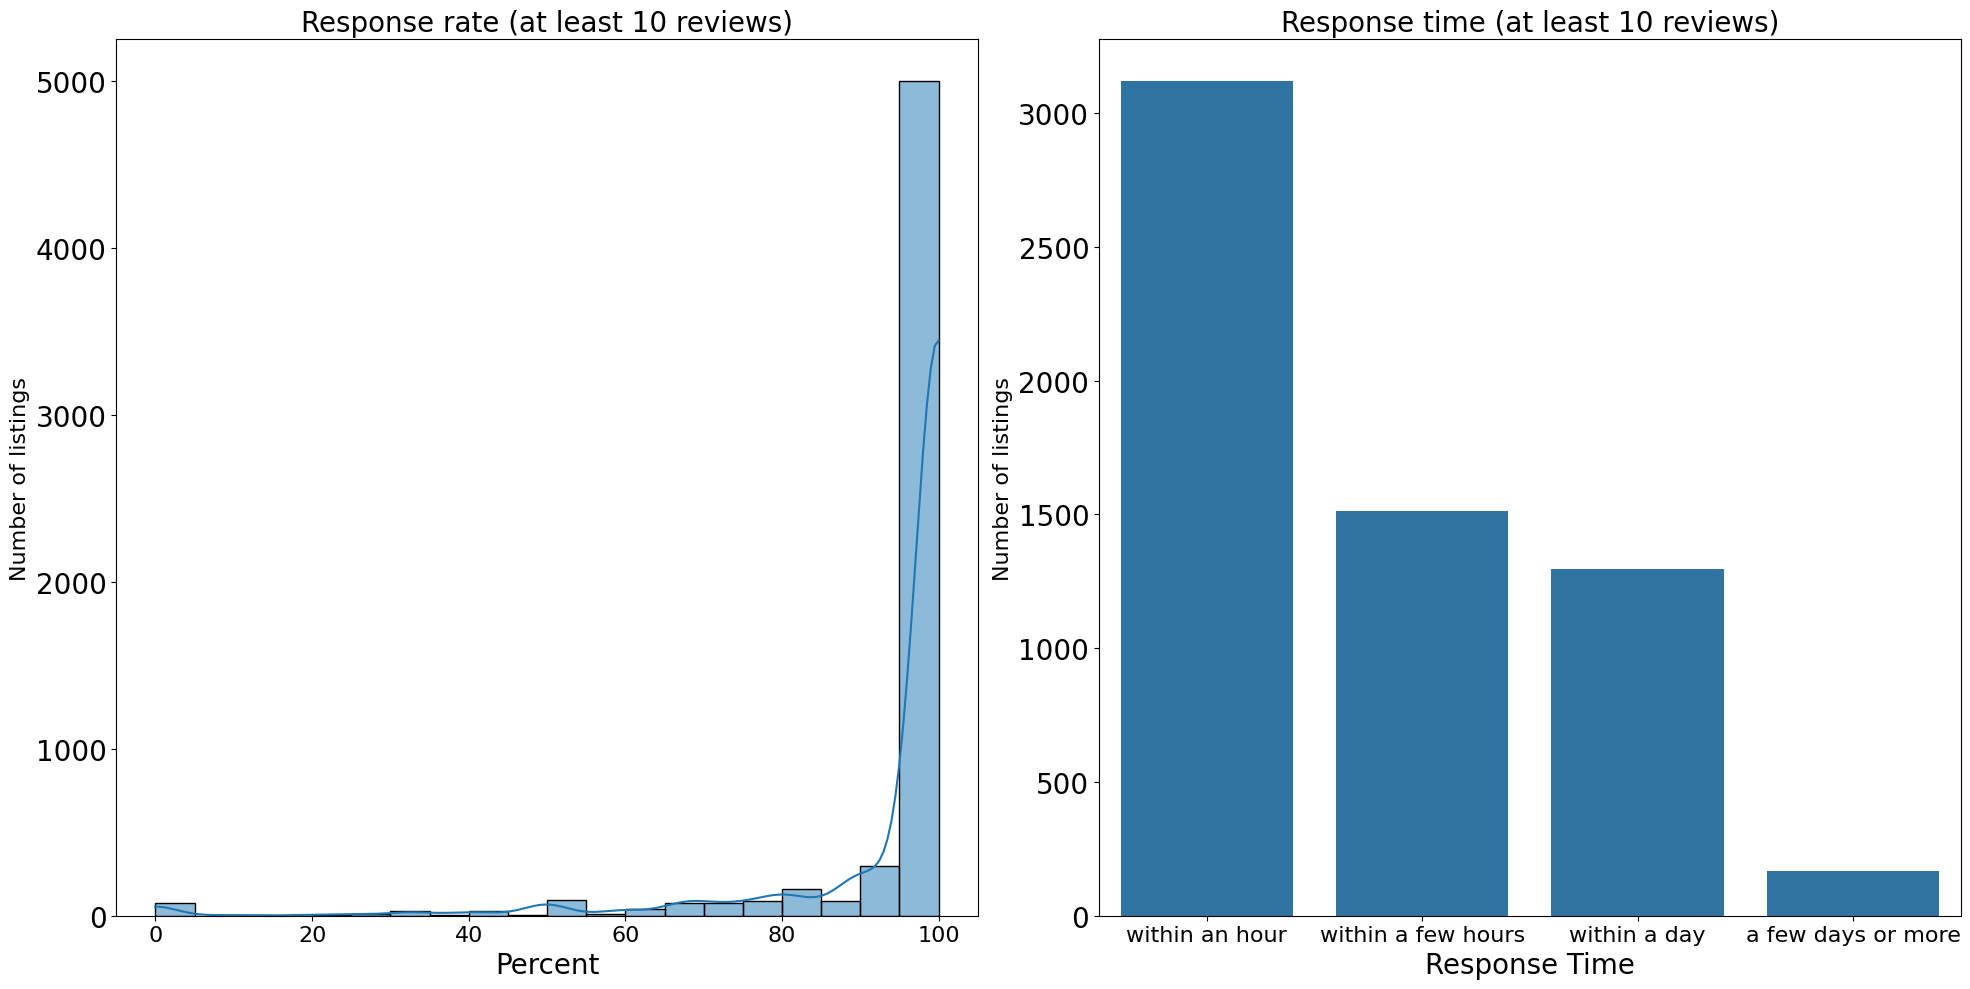

In [34]:
# Create figure and set axis tick sizes
fig = plt.figure(figsize=(20, 10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

# Left subplot for histogram of response rate
ax1 = fig.add_subplot(121)
feq1 = listings10['host_response_rate'].dropna()
sns.histplot(feq1, kde=True, bins=20, ax=ax1)
ax1.set_title("Response rate (at least 10 reviews)", fontsize=20)
ax1.set_xlabel("Percent", fontsize=20)
ax1.set_ylabel("Number of listings", fontsize=16)

# Right subplot for bar plot of response time
ax2 = fig.add_subplot(122)
feq2 = listings10['host_response_time'].value_counts()
sns.barplot(x=feq2.index, y=feq2.values,  ax=ax2)
ax2.set_title("Response time (at least 10 reviews)", fontsize=20)
ax2.set_xlabel("Response Time", fontsize=20)
ax2.set_ylabel("Number of listings", fontsize=16)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


## Disponibilidad en el tiempo
El archivo de calendario contiene 365 registros para cada anuncio, lo que significa que para cada anuncio se especifica el precio y la disponibilidad por fecha con 365 días de antelación.

In [35]:
calendar

,date,available,price
listing_id,,,
2818,2019-12-05,f,NaN
73208,2019-08-30,f,NaN
73208,2019-08-29,f,NaN
73208,2019-08-28,f,NaN
73208,2019-08-27,f,NaN
...,...,...,...
29979667,2018-12-11,t,$139.00
29979667,2018-12-10,t,$139.00
29979667,2018-12-09,t,$139.00


In [36]:
calendar.price = calendar.price.str.replace(",","")
calendar['price'] = pd.to_numeric(calendar['price'].str.strip('$'))
calendar = calendar[calendar.date < '2019-12-05']

In [43]:
print(calendar.shape)

(7290073, 3)


A continuación se muestra una muestra de los datos del calendario. Importante: si la disponibilidad es FALSA, significa que o bien el propietario no desea alquilar su propiedad en esa fecha concreta, o bien el anuncio ya ha sido reservado para esa fecha. Como quiero volver a comparar los precios en la siguiente sección, estoy fusionando la variable «accomodates» con el calendario.

In [44]:
listings.index.name = "listing_id"
calendar = pd.merge(calendar, listings[['accommodates']], on = "listing_id", how = "left")
calendar.sample(15)

,date,available,price,accommodates
listing_id,,,,
12037039,2019-10-11,f,NaN,4
9145411,2019-07-17,f,NaN,4
24902325,2019-08-02,t,199.0,4
10952096,2019-03-27,f,NaN,3
25334792,2019-04-28,f,NaN,2
19749454,2019-05-27,t,125.0,2
26409683,2019-03-25,f,NaN,2
5731584,2019-09-30,f,NaN,2
13991715,2019-05-05,t,210.0,5


A continuación, vemos que hasta tres meses antes suele haber más alojamientos disponibles que más adelante. Esto podría deberse a que los anfitriones actualizan más activamente sus calendarios en este periodo de tiempo. Este gráfico es **interactivo**, y al pasar el ratón por encima de los puntos aparecerá un tooltip con el «número de alojamientos disponibles» y el «día de la semana» por fecha.

In [ ]:
# Assuming sum_available is already prepared as per your code
# You would have this DataFrame already populated from previous steps:
sum_available = calendar[calendar.available == "t"].groupby(['date']).size().to_frame(name='available').reset_index()
sum_available

In [46]:
sum_available['weekday'] = sum_available['date'].dt.day_name()
sum_available['month_day'] = sum_available['date'].dt.day
sum_available['month'] = sum_available['date'].dt.month
sum_available['week']= sum_available['date'].dt.isocalendar().week
sum_available.reset_index(inplace=True,drop=True)
sum_available

,date,available,weekday,month_day,month,week
0,2018-12-06,1188,Thursday,6,12,49
1,2018-12-07,1424,Friday,7,12,49
2,2018-12-08,1723,Saturday,8,12,49
3,2018-12-09,2875,Sunday,9,12,49
4,2018-12-10,3311,Monday,10,12,50
...,...,...,...,...,...,...
359,2019-11-30,3128,Saturday,30,11,48
360,2019-12-01,3156,Sunday,1,12,48
361,2019-12-02,3143,Monday,2,12,49
362,2019-12-03,3144,Tuesday,3,12,49


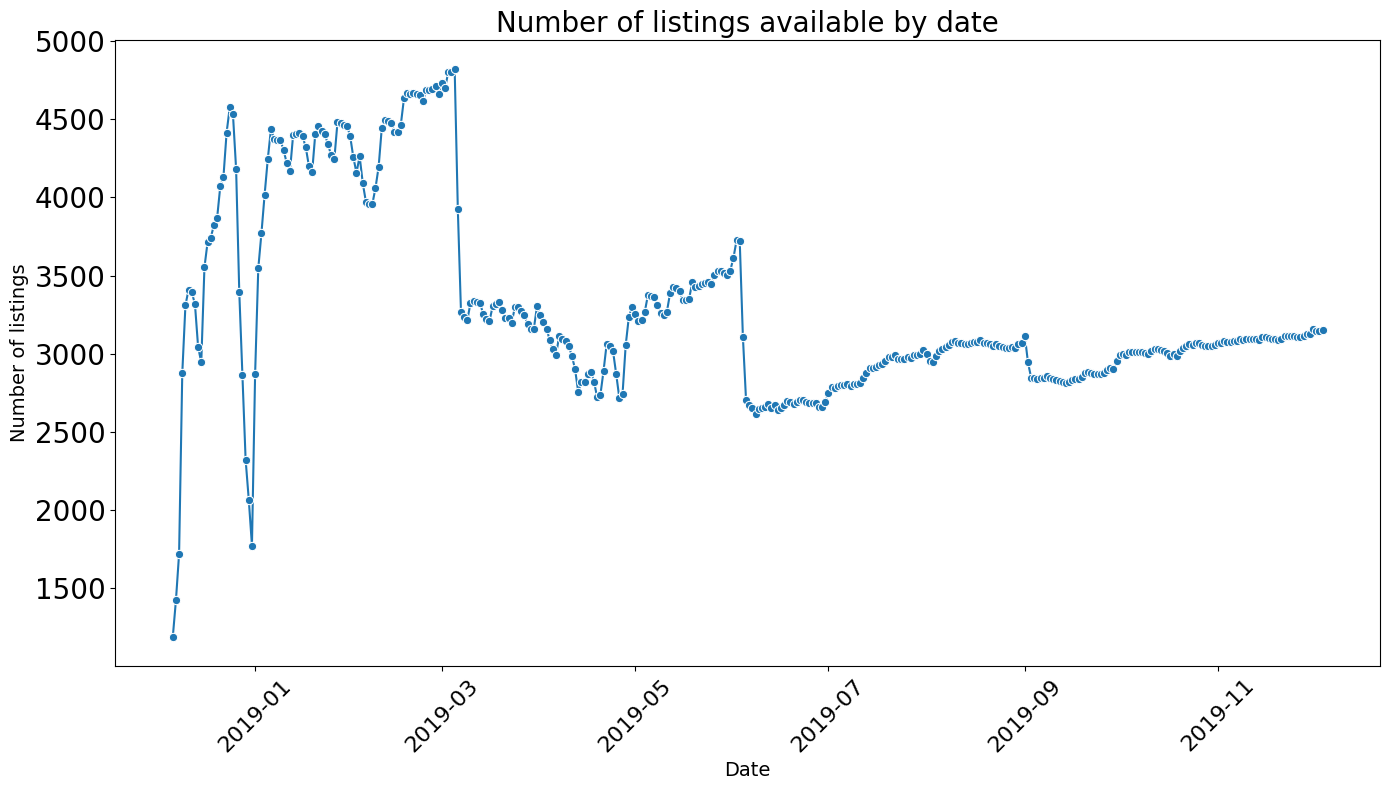

In [47]:
# Plotting using Seaborn
plt.figure(figsize=(14, 8))
sns.lineplot(data=sum_available, x='date', y='available', marker='o')

# Adding titles and labels
plt.title('Number of listings available by date', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of listings', fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

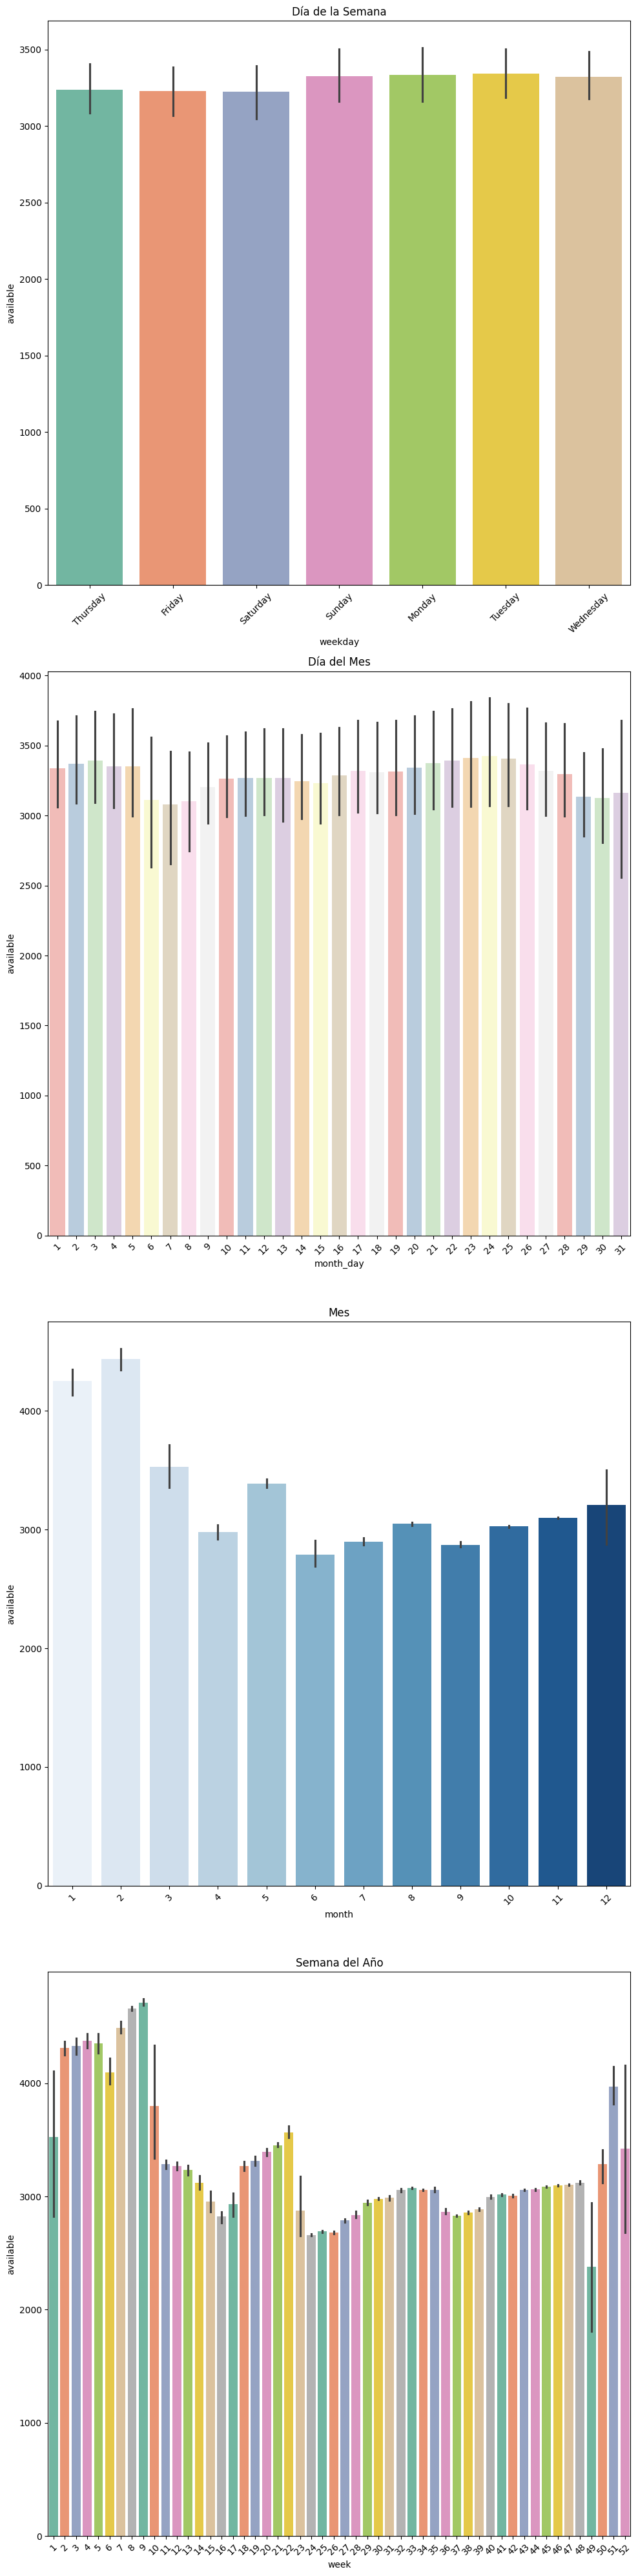

In [48]:
# Asegúrate de que la columna 'date' es de tipo datetime
sum_available['date'] = pd.to_datetime(sum_available['date'])

# Crear subgráficos (4 filas y 1 columna)
fig, axes = plt.subplots(4, 1, figsize=(10, 40))

# Graficar la columna 'weekday' (Día de la semana)
sns.barplot(data=sum_available, x='weekday',y='available', ax=axes[0], palette='Set2')
axes[0].set_title('Día de la Semana')
axes[0].tick_params(axis='x', rotation=45,labelsize=10)
axes[0].tick_params(axis='y', labelsize=10)  # Reducir tamaño de las etiquetas del eje X

# Graficar la columna 'month_day' (Día del mes)
sns.barplot(data=sum_available, x='month_day',y='available', ax=axes[1], palette='Pastel1')
axes[1].set_title('Día del Mes')
axes[1].tick_params(axis='x', rotation=45,labelsize=10)
axes[1].tick_params(axis='y', labelsize=10)  # Reducir tamaño de las etiquetas del eje X

# Graficar la columna 'month' (Mes)
sns.barplot(data=sum_available, x='month',y='available', ax=axes[2], palette='Blues')
axes[2].set_title('Mes')
axes[2].tick_params(axis='x', rotation=45,labelsize=10)
axes[2].tick_params(axis='y', labelsize=10)  # Reducir tamaño de las etiquetas del eje X

# Graficar la columna 'week' (Semana del año)
sns.barplot(data=sum_available, x='week',y='available', ax=axes[3], palette='Set2')
axes[3].set_title('Semana del Año')
axes[3].tick_params(axis='x', rotation=45,labelsize=10)
axes[3].tick_params(axis='y', labelsize=10)  # Reducir tamaño de las etiquetas del eje X

# Ajuste del gráfico
plt.tight_layout()
plt.show()



## Precio medio por fecha
A continuación, puede ver el precio medio de todos los alojamientos para 2 personas marcados como disponibles por fecha. El precio medio máximo de 240 euros es el 31 de diciembre, y el patrón cíclico se debe a los precios más altos de los fines de semana. Sin embargo, sospecho que los precios para fechas más lejanas en el tiempo en su mayoría no se actualizan todavía y son probablemente precios por defecto. Esto puede dar lugar a que el anfitrión no acepte una reserva si se da cuenta de que alguien está intentando reservar algo en una fecha que debería ser más cara de lo habitual. Este gráfico es **interactivo**, y al pasar el ratón por encima de los puntos aparecerá un tooltip con el precio medio y el día de la semana por fecha.

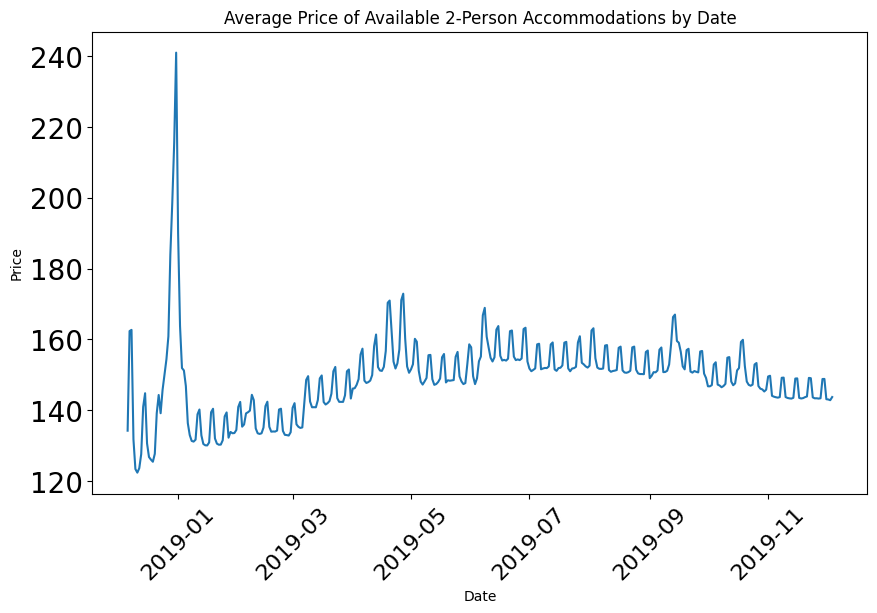

In [49]:
# Filter the dataframe to only include available accommodations for 2 persons
calendar_filtered = calendar[(calendar.available == "t") & (calendar.accommodates == 2)]

# Select only the numeric columns for aggregation
numeric_columns = calendar_filtered.select_dtypes(include=[np.number]).columns

# Perform the groupby and mean calculation on numeric columns
average_price = calendar_filtered.groupby(['date'])[numeric_columns].mean().reset_index()

# Convert 'date' to day of the week
average_price['weekday'] = average_price['date'].dt.day_name()

# Set 'date' as the index
average_price = average_price.set_index('date')

plt.figure(figsize=(10, 6))
sns.lineplot(data=average_price, x=average_price.index, y='price')
plt.title('Average Price of Available 2-Person Accommodations by Date')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()


## Extracción de texto de los comentarios de la Revisión


No creo que los resultados de la minería de texto de los comentarios de revisión sean útiles como consejos específicos para los turistas. Por lo tanto, he creado una sección aparte para ello. ¿Por qué sigo analizando los comentarios? Simplemente porque puedo, y quiero aprender minería de texto con Python de todos modos ;-).

El archivo «reviews» resultó no ser muy interesante, ya que sólo contiene las fechas de las opiniones de cada anuncio, lo que significa que sólo sirve para contar el número de opiniones. El archivo «reviews_details» contiene la misma información (y el mismo número de registros), con 4 columnas adicionales. Además, he fusionado host_id y host_names del anuncio con el archivo reviews_details.

In [37]:
reviews_details.shape

(431830, 6)

In [50]:
reviews_details = pd.merge(reviews_details, listings[['host_id', 'host_name', 'name']], on = "listing_id", how = "left")
reviews_details = reviews_details.set_index('id')
reviews_details = reviews_details[['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id', 'reviewer_name', 'comments']]
reviews_details.head()

,listing_id,name,host_id,host_name,date,reviewer_id,reviewer_name,comments
id,,,,,,,,
1191,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...
1771,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...
1989,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...
2797,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...
3151,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...


A continuación, encontrarás los 5 anfitriones con más opiniones. Es interesante volver a ver los nombres de los anfitriones Martijn y Feliciano, de los que ya se ha hablado antes ;-).

In [51]:
host_reviews = reviews_details.groupby(['host_id', 'host_name']).size().sort_values(ascending=False).to_frame(name = "number_of_reviews")
host_reviews.head()

,,number_of_reviews
host_id,host_name,
1464510,Michiel And Jane,1772
65859990,Martijn,1407
67005410,Feliciano,1350
336950,Manuel,1154
124245,Edwin,1001


In [52]:
reviews_details.comments.head()

id
1191    Daniel is really cool. The place was nice and ...
1771    Daniel is the most amazing host! His place is ...
1989    We had such a great time in Amsterdam. Daniel ...
2797    Very professional operation. Room is very clea...
3151    Daniel is highly recommended.  He provided all...
Name: comments, dtype: object

In [55]:
reviews_details.comments.values[2] #print comment with numbers and windows line break

'we had such a great time in amsterdam. daniel is an excellent host! very friendly and everytime helpful. the room was cozy, comfortable, and very clean. maps, towels, mini-fridge, coffee (very tasty) and tea supplies were provided. bathroom with all the bathroom requires. good location - next to the tram stop and it took just around 10-15 minutes to get to the city center.totally recommendable! '

A continuación hago un preprocesado básico.

In [ ]:

reviews_details = reviews_details[reviews_details['comments'].notnull()]

#remove numbers
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+', '') 
#all to lowercase
reviews_details['comments'] = reviews_details['comments'].str.lower()
#remove windows new line
reviews_details['comments'] = reviews_details['comments'].str.replace('\r\n', "")
#remove stopwords (from nltk library)
stop_english = stopwords.words("english")
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_english)]))
# remove punctuation
reviews_details['comments'] = reviews_details['comments'].str.replace('[^\w\s]'," ")
# replace x spaces by one space
reviews_details['comments'] = reviews_details['comments'].str.replace('\s+', ' ')

reviews_details.comments.values[2] #print same comments again

In addition to removing the stopwords, I also wanted to remove the host names. However the list of host names contains over 5,000 words, and removing those takes a long time. Therefore, I am not removing them yet at this point.

In [56]:
host_names = reviews_details[['host_name']].drop_duplicates()
host_names = host_names.host_name.str.lower().tolist()
len(host_names)

5481

Below you can find my first attempt to find the most used words using the CountVectorizer() function of sklearn.

In [57]:

texts = reviews_details.comments.tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

,words,counts
4,the,1011525
8,and,911633
24,to,568595
6,was,425782
1,is,407608
20,in,376195
74,we,310762
10,very,306418
62,of,234280
99,it,213233


In [ ]:

cvec_dict = dict(zip(cvec_df.words, cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Análisis inferencial

- Hipótesis nula (H₀): No hay relación entre el tipo de propiedad y si el anfitrión es un superanfitrión.
- Hipótesis alternativa (H₁): Hay una relación significativa entre el tipo de propiedad y si el anfitrión es un superanfitrión.

In [ ]:


# Crea una tabla de contingencia entre 'property_type' y 'host_is_superhost'
contingency_table = pd.crosstab(listings['property_type'], listings['host_is_superhost'])

# Realiza la prueba de Chi-cuadrado
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Definición de hipótesis
print("Hipótesis:")
print("H₀: No hay relación entre el tipo de propiedad y si el anfitrión es un superanfitrión (son independientes).")
print("H₁: Hay una relación entre el tipo de propiedad y si el anfitrión es un superanfitrión (no son independientes).")

# Resultados
print(f"\nValor p: {p_val}")
print(f"Estadístico Chi-cuadrado: {chi2_stat}")

# Interpretación del valor p
alpha = 0.05  # Nivel de significancia

if p_val < alpha:
    print("\nSe rechaza la hipótesis nula (H₀). Hay evidencia suficiente para afirmar que hay una relación entre el tipo de propiedad y si el anfitrión es un superanfitrión.")
else:
    print("\nNo se rechaza la hipótesis nula (H₀). No hay suficiente evidencia para afirmar que haya una relación entre el tipo de propiedad y si el anfitrión es un superanfitrión.")





Para probar si una variable numérica sigue una distribución normal, puedes usar la prueba de Shapiro-Wilk. Vamos a aplicar esto a una de las puntuaciones de reseñas, como review_scores_value.
- Hipótesis nula (H₀): Los datos siguen una distribución normal.
- Hipótesis alternativa (H₁): Los datos no siguen una distribución normal.

In [ ]:


# Filtra la columna de puntuación
data = listings['review_scores_value'].dropna()

# Realiza la prueba de normalidad de Shapiro-Wilk
stat, p_val = shapiro(data)

# Resultados
print(f"Estadístico de Shapiro-Wilk: {stat}")
print(f"Valor p: {p_val}")

# Si p < 0.05, la variable no sigue una distribución normal
if p_val < 0.05:
    print("Los datos no siguen una distribución normal")
else:
    print("Los datos siguen una distribución normal")


In [ ]:
# Filtra las columnas necesarias
property_types = listings['property_type'].unique()  # Obtiene todos los tipos de propiedades

# Verificar si hay grupos vacíos
groups = []
for prop in property_types:
    group_data = listings[listings['property_type'] == prop]['review_scores_value'].dropna()
    if group_data.shape[0] > 1:  # Asegúrate de que cada grupo tenga más de un valor
        groups.append(group_data)
    else:
        print(f"Grupo vacío o insuficiente en: {prop}")

# Si hay suficientes grupos, realiza la prueba ANOVA
if len(groups) > 1:
    f_stat, p_val = f_oneway(*groups)

    # Resultados
    print(f"Valor p: {p_val}")
    print(f"Estadístico F: {f_stat}")

    # Interpretación del valor p
    alpha = 0.05  # Nivel de significancia
    if p_val < alpha:
        print("\nSe rechaza la hipótesis nula (H₀). Hay evidencia suficiente para afirmar que las medias de las puntuaciones de reseñas son significativamente diferentes entre los tipos de propiedades.")
    else:
        print("\nNo se rechaza la hipótesis nula (H₀). No hay suficiente evidencia para afirmar que las medias de las puntuaciones de reseñas son diferentes entre los tipos de propiedades.")
else:
    print("No hay suficientes grupos con datos válidos para realizar la prueba ANOVA.")
